# lda models
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


#tfidf https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76


https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [1]:
# maths
from collections import Counter
from numpy import array, log
from scipy.stats import entropy
import pandas as pd
import numpy as np

# grapjs
import seaborn as sns
import matplotlib.pyplot as plt

# text editing
import os
import re
import string
import unidecode

# gensim
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.utils import simple_preprocess

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# sklearn
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.manifold import TSNE

# LDA visualization
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis


import pickle
import warnings

unable to import 'smart_open.gcs', disabling that module


# Read Books

In [2]:
# obras
folder = 'Machado/'
titles = os.listdir(folder)

# 5 obras de Machado de Assis
# cuidado! originais! outra norma ortografia!
print(titles)

# abrir documento
corpus = open(folder+titles[0],'r',encoding='utf-8-sig').read().split('\n')

clean_corpus = []
skip_next = False

# clean
for line in corpus:
    if line == '':
        continue
    if skip_next:
        skip_next = False
        continue
    if line[:8] == 'CAPITULO':
        skip_next = True
        continue
    if len(line)<=5:
        continue
    clean_corpus.append(line)
corpus = clean_corpus

# paragrafos
paragraphs = []
sup = []
for line in corpus:
    sup.append(line)
    if line[-1] in {'.','!','?',':'}:
        # um paragrafo = uma string
        sup = ''.join(s+' ' for s in sup)[:-1]
        paragraphs.append(sup)
        sup = []
print('# de paragrafos:',len(paragraphs))

# frases
paragraphs_sents = [sent_tokenize(p) for p in paragraphs]
sentences = [item for sublist in paragraphs_sents for item in sublist]
print('# de frases:',len(sentences))


# palavras
sentences_words = [word_tokenize(s) for s in sentences]

def clean_sentence(words,stop='portuguese'):
    
    # palavras (minuscula, ex pontuaçao)
    words = [re.sub(r'['+string.punctuation+']','',word.lower()) for word in words]
    # take accents out
    words = [unidecode.unidecode(word) for word in words]
    # take blank lines out
    words = [word for word in words if word != '']
    if type(stop)==str:
        stop_words = [unidecode.unidecode(word) for word in stopwords.words(stop)]
        stop_words = set(stop_words)
        words = [word for word in words if word not in stop_words]
    return words

sentences_dirty = [clean_sentence(words,stop=None) for words in sentences_words]
words_dirty = [item for sublist in sentences_dirty for item in sublist]
print('# de palavras (sujo):',len(words_dirty))

sentences_clean = [clean_sentence(words) for words in sentences_words]
words_clean = [item for sublist in sentences_clean for item in sublist]
print('# de palavras (limpo):',len(words_clean))

['BrazCubas.txt', 'DomCasmurro.txt', 'EsauJacob.txt', 'MaoLuva.txt', 'QuincasBorba.txt']
# de paragrafos: 1253
# de frases: 3674
# de palavras (sujo): 60093
# de palavras (limpo): 33165


In [3]:
print(stopwords.words('Portuguese'))

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [4]:
df_all = pd.DataFrame(pd.DataFrame(words_dirty,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})

# o primeiro substantivo é a 32a palavra
print(df_all[df_all.words=='virgilia'])
df_all.head(50)

       words  counts
30  virgilia     199


,words,counts
0,a,2786
1,e,2519
2,que,2196
3,de,2087
4,o,1803
5,nao,1171
6,um,985
7,do,707
8,uma,662
9,da,659


# Zipf Distribution

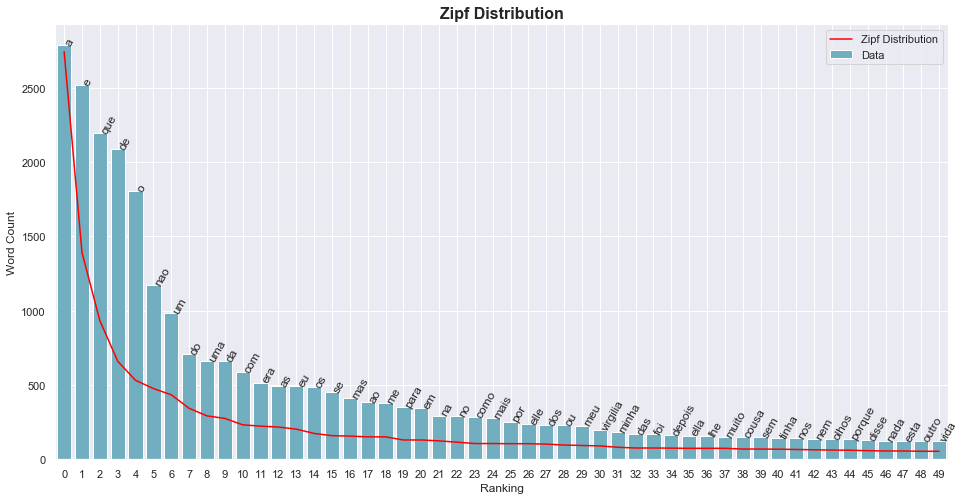

In [5]:
# Lei de Zipft

def optimize_zipf(counts,print_optimal=False):
    prob = counts/sum(counts)
    # functions
    f_lzipf = lambda s,n: array([-s*log(i) for i in range(1,n+1)])-log(sum([1/(i**s) for i in range(1,n+1)]))
    f_ssr = lambda s: sum((log(prob)-f_lzipf(s,len(prob)))**2)
    # minimization
    ssr = array([(i/100,f_ssr(i/100)) for i in range(50,200)])
    ssr = pd.DataFrame(ssr,columns=['s','ssr'])
    optimal = ssr[ssr.ssr==min(ssr.ssr)]
    if print_optimal:
        print(optimal)   
    zipf_param = optimal.s.values[0]
    if zipf_param<=1:
        if print_optimal:
            print(zipf_param)
        zipf_param = 1.001
    return zipf_param

def plot_zipf(df,zipf_param=1.0001,cut=50,annotate=True):
    
    # data
    counts = df.counts.values
    if zipf_param <= 1: zipf_param = optimize_zipf(words)
    zipf = sorted(Counter(np.random.zipf(a=zipf_param,size=sum(df.counts.values))).values(),reverse=True)
    
    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    # theoretical
    sns.lineplot(x=[i for i in range(cut)],
                 y=zipf[:cut],
                 label='Zipf Distribution',
                 color='red')
    # empirical
    sns.barplot(x=[i for i in range(cut)],
                y=counts[:cut],
                label='Data',
                color='c')
    # annotate
    if annotate:
        for c in range(cut):
            plt.annotate(df.values[c,0],(c,df.values[c,1]),rotation=60)
        
    # labels
    #ax.set_xlim(0,cut)
    ax.set_title('Zipf Distribution',fontweight='bold',fontsize='16')
    ax.set_ylabel('Word Count')
    ax.set_xlabel('Ranking')
    plt.legend(loc='upper right')
    plt.grid(ls='-')

    # show
    plt.show()

# todas as palavras
df_all = pd.DataFrame(pd.DataFrame(words_dirty,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})
plot_zipf(df_all,1.001)

# ex stop words
#df_clean = pd.DataFrame(pd.DataFrame(words_clean,columns=['counts'])['counts'].value_counts()).reset_index().rename(columns={'index':'words'})
#plot_zipf(df_clean,1.001)

# TF-IDF

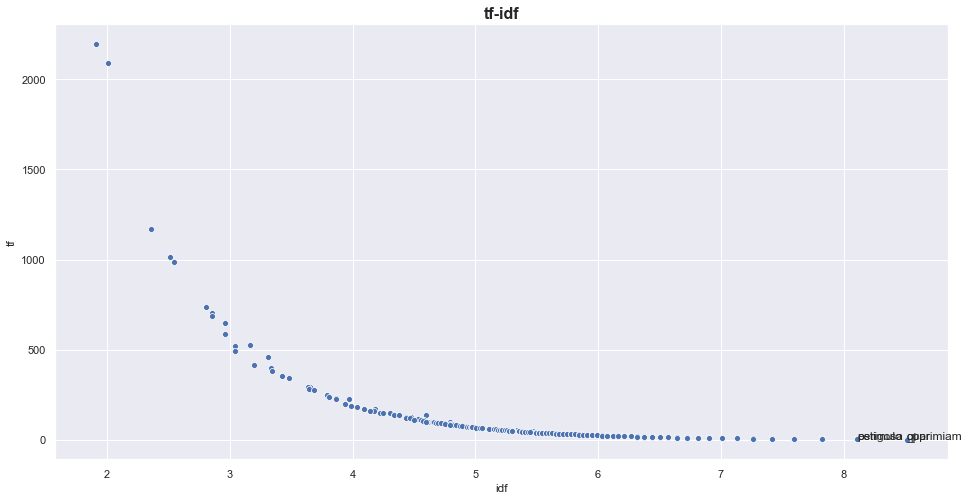

In [6]:
def return_tfidf(corpus):
    cv = CountVectorizer()
    word_count_vector = cv.fit_transform(corpus)
    # normalization
    tfidf_transformer = TfidfTransformer(norm='l2',
                                         use_idf=True,
                                         smooth_idf=True,
                                         sublinear_tf=False)
    tfidf_transformer.fit(word_count_vector)
    count_vector = cv.transform(corpus)
    tf_idf_vector = tfidf_transformer.transform(count_vector)
    # dataframe
    df = pd.DataFrame(index=cv.get_feature_names())
    df["idf"] = np.array(tfidf_transformer.idf_)
    df["tf"] = count_vector.sum(axis=0).T
    #df["tfidf"] = 
    df = df.sort_values(by=["tf"],ascending=False)
    df = df.drop_duplicates()
    return df

def plot_tfidf(df,top=5,bottom=0):

    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))

    sns.scatterplot(x=df.idf,
                    y=df.tf)

    # annotate
    for t in range(len(df)-top,len(df)):
        plt.annotate(df.index[t],(df.iloc[t].idf,df.iloc[t].tf*1.05))
        
    for t in range(bottom):
        plt.annotate(df.index[t],(df.iloc[t].idf,df.iloc[t].tf*1.05))
        
    # labels
    #ax.set_xlim(0,cut)
    ax.set_title('tf-idf',fontweight='bold',fontsize='16')
    ax.set_xlabel('idf')
    ax.set_ylabel('tf')
    #plt.legend(loc="upper right")
    plt.grid(ls='-')

    # show
    plt.show()

sup = [''.join(word+' ' for word in sentence) for sentence in sentences_words]
df_tfidf = return_tfidf(sup)

plot_tfidf(df_tfidf)

## Ngrams
### 1. Bigrams and Trigrams with NLTK

In [7]:
def gimme_ngrams(words,n=2):
    if n==2:
        finder = BigramCollocationFinder.from_words(words)
        ngram_m = BigramAssocMeasures()
    else:
        finder = TrigramCollocationFinder.from_words(words)
        ngram_m = TrigramAssocMeasures()        
    # alternative: score=ngram_m.chi_sq
    score = ngram_m.mi_like
    collocations = {'_'.join(ngram): pmi for ngram, pmi in finder.score_ngrams(score)}
    return collocations

# words_clean = list of strings
bigrams = gimme_ngrams(words_clean,n=2)
trigrams = gimme_ngrams(words_clean,n=3)

# df
df_bigram = pd.DataFrame(bigrams.values(),
                         index=bigrams.keys()
                        ).reset_index().rename(columns={'index':'bigram',0:'assoc'})
df_trigram = pd.DataFrame(trigrams.values(),
                         index=trigrams.keys()
                        ).reset_index().rename(columns={'index':'trigram',0:'assoc'})

# filtering: >1 is ok; > 1.5 is more stringent
df_bigram = df_bigram[df_bigram.assoc>1]
#df_trigram = df_trigram[df_trigram.assoc>1]

# show
# bigrams seem informative
df_bigram.head(50)

,bigram,assoc
0,quincas_borba,57.563461
1,lobo_neves,51.018868
2,d_placida,38.453291
3,braz_cubas,11.873100
4,alguma_cousa,7.280681
5,rio_janeiro,5.444444
6,d_eusebia,5.127907
7,dia_seguinte,3.471139
8,arma_virumque,3.125000
9,alguns_instantes,2.400427


### 1. Bigrams and Trigrams with Gensim

In [46]:
# create bigrams

bigram = gensim.models.Phrases(sentences_clean,min_count=2,threshold=300)
bigram_model = gensim.models.phrases.Phraser(bigram)

# show
sup_big = bigram_model.phrasegrams.keys()
print('Total bigrams:',len(sup_big))
for i in sup:
    print(i)

Total bigrams: 62
(b'algum', b'tempo')
(b'cousa', b'nenhuma')
(b'deixeime', b'estar')
(b'nada', b'menos')
(b'outro', b'lado')
(b'braz', b'cubas')
(b'tio', b'conego')
(b'rio', b'janeiro')
(b'idea', b'fixa')
(b'alguma', b'vez')
(b'muitas', b'vezes')
(b'la', b'ia')
(b'dous', b'annos')
(b'deste', b'livro')
(b'outro', b'tempo')
(b'pode', b'ser')
(b'si', b'mesma')
(b'alguma', b'cousa')
(b'desta', b'vez')
(b'disse', b'ella')
(b'vida', b'morte')
(b'alguns', b'annos')
(b'alguns', b'instantes')
(b'disse', b'commigo')
(b'mesma', b'cousa')
(b'tio', b'joao')
(b'outra', b'cousa')
(b'alguns', b'dias')
(b'tres', b'quatro')
(b'd', b'eusebia')
(b'dia', b'seguinte')
(b'nesta', b'pagina')
(b'quincas', b'borba')
(b'primeira', b'vez')
(b'tres', b'dias')
(b'outra', b'vez')
(b'devia', b'ser')
(b'disse', b'elle')
(b'outras', b'vezes')
(b'primeiros', b'dias')
(b'nesse', b'dia')
(b'meia', b'hora')
(b'disseme', b'elle')
(b'capitulo', b'anterior')
(b'lobo', b'neves')
(b'ponta', b'nariz')
(b'luiz', b'dutra')
(b'pod

# Entropia

In [73]:
sup = array(list(Counter(words_clean).values()))
sup = sup/sup.sum()
ent = entropy(sup)
ent

8.277748336200851

# Word Embeddings

In [74]:
# initialize model
w2v_model = Word2Vec(window=15, 
                     hs=0,
                     sample=0.000001,
                     negative=5, 
                     min_count=10,
                     workers=-1, 
                     iter=100)

w2v_model.build_vocab(sentences_words,
                      progress_per=10000)

w2v_model.train(sentences=sentences_words,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_model.epochs)

print('Vocabulario:',len(w2v_model.wv.vocab))
#print(list(w2v_model.wv.vocab.keys())[:10])

# exemplo de palavras proximas
print(w2v_model.wv.most_similar(positive='arte',topn=10))

Vocabulario: 710
[('unico', 0.3096269369125366), ('fiz', 0.3004605770111084), ('unica', 0.27306368947029114), ('--', 0.2675236761569977), ('entrar', 0.24741631746292114), ('papel', 0.23787392675876617), ('cuja', 0.2285296618938446), ('theatro', 0.2285269945859909), ('noticia', 0.22326278686523438), ('remorsos', 0.21767735481262207)]


In [75]:
def tsnescatterplot(model, word, list_names):
    
    """
    Steps:
    1. Builds arrays with highlighted word, 10 closest words and 10 words given
    2. Does PCA dimensionality reduction to 50 (or whatever possible)
    3. Does t-SNE dimensionality reduction
    4. Plots in seaborn
    
    Color code:
    -> query word: red
    -> closest words: blue
    -> other given words: green
    """
    arrays = np.empty((0, len(w2v_model.wv[word])), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for close_word in close_words:
        word_vector = model.wv.__getitem__([close_word[0]])
        word_labels.append(close_word[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for name in list_names:
        word_vector = model.wv.__getitem__([name])
        word_labels.append(name)
        color_list.append('green')
        arrays = np.append(arrays, word_vector, axis=0)
    
    
    # Reduces the dimensionality from 300 to 50 dimensions with PCA (or the required)
    reduc = PCA(n_components = min(arrays.shape[0], arrays.shape[1], 50)).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [ ]:
# analogia
w2v_model.wv.most_similar(positive=["homer", "woman"], negative=["marge"], topn=3)

# menos semelhante
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

# Decompositions

In [76]:
# data
list_of_strings = [[''.join(word+' ' for word in sentence)][0] for sentence in sentences_clean]
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   analyzer='word',
                                   min_df=0.001,
                                   max_df=0.5,
                                   sublinear_tf=True,
                                   use_idf=True)
ncomps=2
X = tfidf_vectorizer.fit_transform(list_of_strings)

In [77]:
# display similars
terms = tfidf_vectorizer.get_feature_names()
def show_topics(component,vocabulary,topn=5):
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in component])
    return [', '.join(t) for t in topic_words]

### 1. Singular Value Decomposition (SVD)

In [78]:
# svd decompostion
svd = TruncatedSVD(n_components=ncomps,
                   random_state=42)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

# top 5 values
print('SVD:')
print('Explained variance:',np.cumsum(svd.explained_variance_))
sup = sorted(show_topics(V, terms))
for i in range(min(5,len(sup))):
    print(i,sup[i])

SVD:
Explained variance: [0.00413326 0.01053444]
0 virgilia, disse, elle, ella, nada
1 virgilia, ficou, perguntou, marido, perguntou virgilia


### 2. Non-Negative Matrix Factorization (NMF)

In [79]:
# nmf decompostion
nmf = NMF(n_components=ncomps,
          init='nndsvd',
          random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# top 5 values
print('\nNMF:')
sup = sorted(show_topics(H, terms))
for i in range(min(5,len(sup))):
    print(i,sup[i])


NMF:
0 disse, elle, ella, nada, cousa
1 virgilia, ficou, marido, perguntou, olhos


## 3. Ploting words

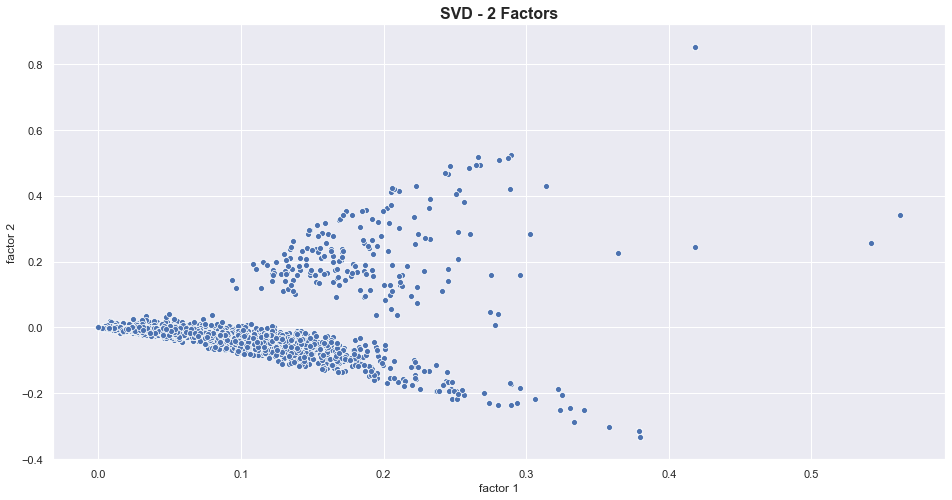

In [82]:
def plot_2d(X,Y,title='',xlabel='X',ylabel=''):

    # plot
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1,1,figsize=(16,8))

    sns.scatterplot(x=X,
                    y=Y)

    # labels
    ax.set_title(title,fontweight='bold',fontsize='16')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #plt.legend(loc="upper left")
    plt.grid(ls='-')

    # show
    plt.show()
    
plot_2d(X=U[:,0],
        Y=U[:,1],
        title='SVD - 2 Factors',
        xlabel='factor 1',
        ylabel='factor 2')

In [83]:
def tsnescatterplot(model, word, list_names):
    
    """
    Steps:
    1. Builds arrays with highlighted word, 10 closest words and 10 words given
    2. Does PCA dimensionality reduction to 50 (or whatever possible)
    3. Does t-SNE dimensionality reduction
    4. Plots in seaborn
    
    Color code:
    -> query word: red
    -> closest words: blue
    -> other given words: green
    """
    arrays = np.empty((0, len(w2v_model.wv[word])), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for close_word in close_words:
        word_vector = model.wv.__getitem__([close_word[0]])
        word_labels.append(close_word[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for name in list_names:
        word_vector = model.wv.__getitem__([name])
        word_labels.append(name)
        color_list.append('green')
        arrays = np.append(arrays, word_vector, axis=0)
    
    
    # Reduces the dimensionality from 300 to 50 dimensions with PCA (or the required)
    reduc = PCA(n_components = min(arrays.shape[0], arrays.shape[1], 50)).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    
# 10 random words
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah',
                                     'maude', 'bob', 'mel',
                                     'apu', 'duff', 'selma',
                                     'patty','beer','bart',
                                     'homer'])

KeyError: "word 'homer' not in vocabulary"

### 1. BOW LDA with Gensim

In [84]:
# no easy lemmatizer in portuguese
# stemming
stemmer = SnowballStemmer('portuguese')
sentences_stem = [[stemmer.stem(word) for word in sentence] for sentence in sentences_clean]

In [85]:
# processing
processed_docs = sentences_stem
dictionary = gensim.corpora.Dictionary(sentences_stem)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
num_topics = 10

# model
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=num_topics,
                                       id2word=dictionary,
                                       passes=3)

# show
topics = lda_model.show_topics(num_topics=10,num_words=10,log=False,formatted=False)
for topic in topics:
    print('Topic:',topic[0])
    print('Words:',list(array(topic[1])[:,0]))
    print()

Topic: 0
Words: ['borb', 'cas', 'quinc', 'agor', 'quer', 'mar', 'elle', 'faz', 'lev', 'mulh']

Topic: 1
Words: ['pouc', 'vez', 'dia', 'cas', '<<', 'polit', 'diz', 'grand', 'nenhum', 'cont']

Topic: 2
Words: ['nad', 'annos', 'tod', 'ouv', 'cous', 'filh', 'vez', 'outr', 'palavr', 'tao']

Topic: 3
Words: ['virgil', 'outr', 'temp', 'mort', 'cub', 'filh', 'vid', 'diss', 'braz', 'mod']

Topic: 4
Words: ['outr', 'porqu', 'elle', 'hom', 'tod', 'cheg', 'sab', 'vid', 'ella', 'mim']

Topic: 5
Words: ['algum', 'diz', 'elle', 'outr', 'cous', 'olhos', 'talvez', 'ide', 'temp', 'cas']

Topic: 6
Words: ['la', 'pass', 'elle', 'ella', 'virgil', 'senhor', 'aind', 'tant', 'vinh', 'tod']

Topic: 7
Words: ['cous', 'pod', 'ser', 'nev', 'lob', 'algum', 'outr', 'enta', 'nunc', 'mesm']

Topic: 8
Words: ['men', 'diss', 'ella', 'cous', 'assim', 'outr', 'amor', 'virgil', 'tud', 'sim']

Topic: 9
Words: ['d', 'tod', 'plac', 'pod', 'fic', 'cas', 'elle', 'palavr', 'tao', 'cont']



### 2. TF-IDF LDA with Gensim

In [86]:
# processing
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# model
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             num_topics=num_topics,
                                             id2word=dictionary,
                                             passes=3)

# show
topics = lda_model_tfidf.show_topics(num_topics=10,num_words=10,log=False,formatted=False)
for topic in topics:
    print('Topic:',topic[0])
    print('Words:',list(array(topic[1])[:,0]))
    print()

Topic: 0
Words: ['elle', 'diss', 'sim', 'plac', 'marcell', 'd', 'olhos', 'velh', 'tal', 'esquec']

Topic: 1
Words: ['filh', 'pod', 'primeir', 'dias', 'pobr', 'cas', 'amor', 'talvez', 'mao', 'simpl']

Topic: 2
Words: ['virgil', 'senhor', 'lob', 'nev', 'pergunt', 'polit', 'amig', 'ache', 'just', 'naquell']

Topic: 3
Words: ['fic', 'nad', 'ser', 'nenhum', 'vou', 'respond', 'ded', 'mulh', 'philosoph', 'outr']

Topic: 4
Words: ['outr', 'vez', 'alguns', 'annos', 'fiqu', 'natural', 'sei', 'tant', 'dir', 'mesm']

Topic: 5
Words: ['ella', 'diss', 'ora', 'diab', 'assim', 'mar', 'mae', 'fac', 'cinc', 'nunc']

Topic: 6
Words: ['mort', 'enta', 'dia', 'borb', 'sab', 'gost', 'outr', 'cous', 'quinc', 'd']

Topic: 7
Words: ['faz', 'ide', 'porqu', 'grand', 'ah', 'temp', 'verdadeir', 'pouc', 'fiz', 'precis']

Topic: 8
Words: ['men', 'quer', 'parec', 'cub', 'cas', 'outr', 'deus', 'cart', 'viv', 'elle']

Topic: 9
Words: ['diz', 'pois', 'deix', 'agor', 'tud', 'vez', 'ar', 'capitul', 'aind', 'tao']



### 3. LDA with LDAvis

In [87]:
warnings.simplefilter("ignore", DeprecationWarning)

# Initialise the count vectorizer with the English stop words
list_of_strings = [[''.join(word+' ' for word in sentence)][0] for sentence in processed_docs]
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(list_of_strings)

def print_topics(model, count_vectorizer, n_top_words=10):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print('Topic:',topic_idx)
        print('Words:',' '.join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
        
# Create and fit the LDA model
lda = LDA(n_components=num_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print('LDA')
print_topics(lda, count_vectorizer)

LDA
Topic: 0
Words: cas borb quinc ella tod enta elle vid olhos outr

Topic: 1
Words: tod pod outr plac elle assim ser pass pens virgil

Topic: 2
Words: outr nad ide diz cous mim faz sei cert men

Topic: 3
Words: virgil outr olhos filh pod diss nev algum deix lob

Topic: 4
Words: outr elle vez cub olhos diz algum hom ella braz

Topic: 5
Words: quer senhor outr cous cas diz dev algum vid tod

Topic: 6
Words: temp vez elle sab pae cous outr tao algum acab

Topic: 7
Words: cous diss algum tod outr ella cert pod mesm annos

Topic: 8
Words: elle tod cont olhos cas pass virgil dig pouc pobr

Topic: 9
Words: porqu ser hor primeir outr dia vid elle cas hav



In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
#pyLDAvis.save_html(LDAvis_prepared, 'ldavis/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared